In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import requests

import pandas as pd
import random
import numpy as np

covid_path = os.path.join('/content','drive','My Drive','covid')


In [71]:
rilevazioni = pd.read_csv('/content/drive/My Drive/IT/Python/covid/rilevazioni.csv').set_index(['Regione','Citta'])
rilevazioni.iloc[:,15:]

23-03  24-03  25-03  ...  04-04  05-04  06-04
Regione   Citta                                 ...                     
LOMBARDIA BERGAMO           6471   6728   7072  ...   9588   9712   9815
          BRESCIA           5905   6298   6597  ...   9180   9340   9477
          COMO               581    635    706  ...   1319   1384   1473
          CREMONA           2925   3061   3156  ...   4154   4233   4260
          LECCO              934   1015   1076  ...   1628   1678   1712
...                          ...    ...    ...  ...    ...    ...    ...
CALABRIA  COSENZA             68     84     99  ...    204    230    243
          REGGIO CALABRIA     94     97    105  ...    222    237    243
          CATANZARO           46     49     51  ...    150    157    158
          VIBO VALENTIA       20     21     23  ...     57     60     60
          CROTONE             62     66     71  ...    106    109    111

[108 rows x 15 columns]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(15, 7)):
  
  ax = df.T.plot(figsize=figsize, title=title)
  ax.set_xticks(ticks=np.arange(0, len(df.columns), step=1))
  ax.set_xticklabels(list(df.columns))

  for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
    for el in v[1]:
      ax.annotate(el, (k + xdelta, el + ydelta))
  return ax

In [0]:
sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]

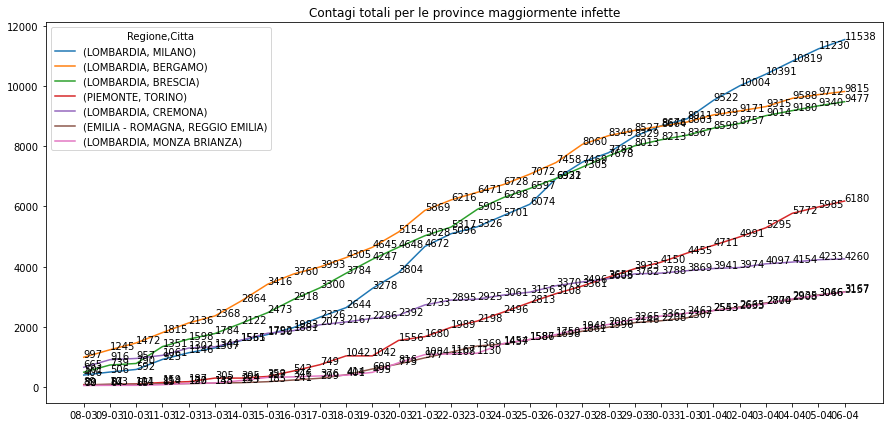

In [74]:
_ = plot_annotate(sorted_by_infections.head(7),'Contagi totali per le province maggiormente infette')

In [0]:
crescita = pd.DataFrame(index=sorted_by_infections.index)

In [0]:
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

In [77]:
display(crescita.head(3))
sorted_by_infections.head(3)

09-03  10-03  11-03  12-03  ...  03-04  04-04  05-04  06-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     100     86    333    221  ...    387    428    411    308
          BERGAMO    248    227    343    321  ...    144    273    124    103
          BRESCIA    238     51    561    247  ...    257    166    160    137

[3 rows x 29 columns]

08-03  09-03  10-03  11-03  ...  03-04  04-04  05-04  06-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     406    506    592    925  ...  10391  10819  11230  11538
          BERGAMO    997   1245   1472   1815  ...   9315   9588   9712   9815
          BRESCIA    501    739    790   1351  ...   9014   9180   9340   9477

[3 rows x 30 columns]

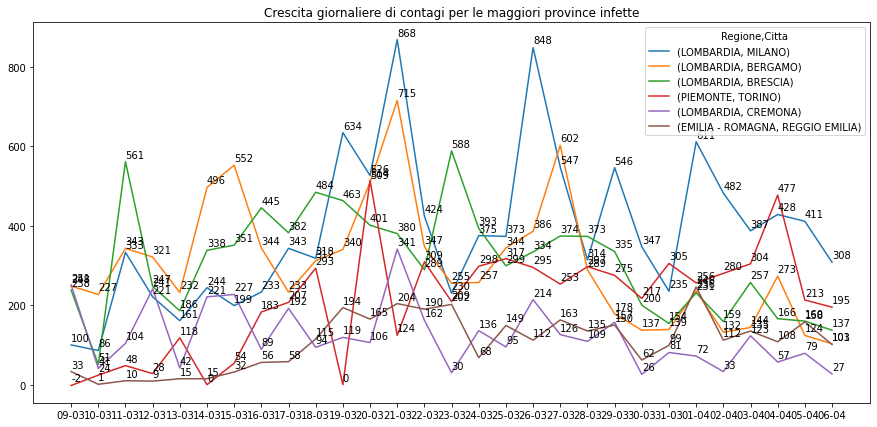

In [78]:
_ = plot_annotate(crescita.head(6), 'Crescita giornaliere di contagi per le maggiori province infette')

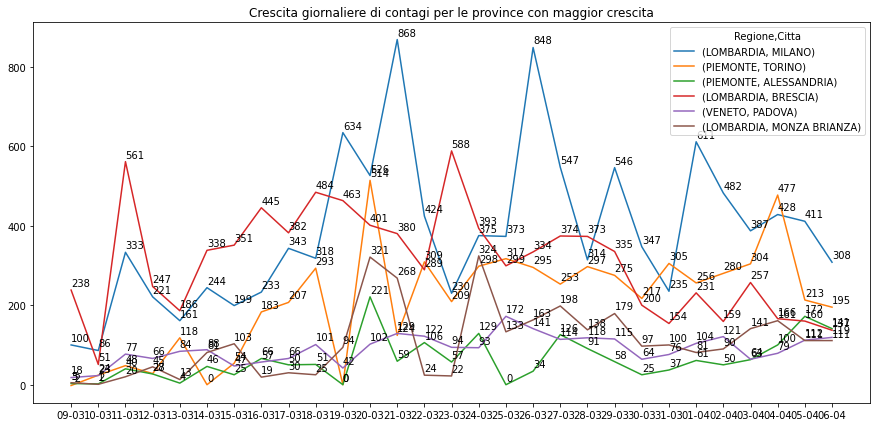

In [79]:
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(6),
                   'Crescita giornaliere di contagi per le province con maggior crescita')
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

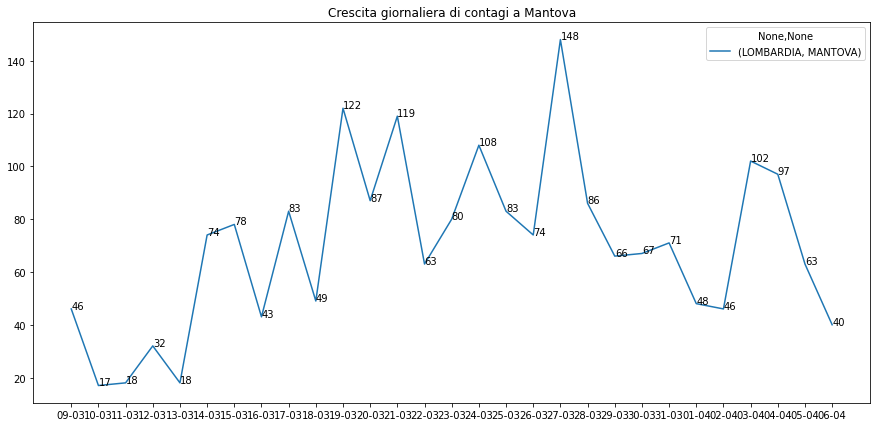

In [80]:
_ = plot_annotate(crescita.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Crescita giornaliera di contagi a Mantova', ydelta=0)

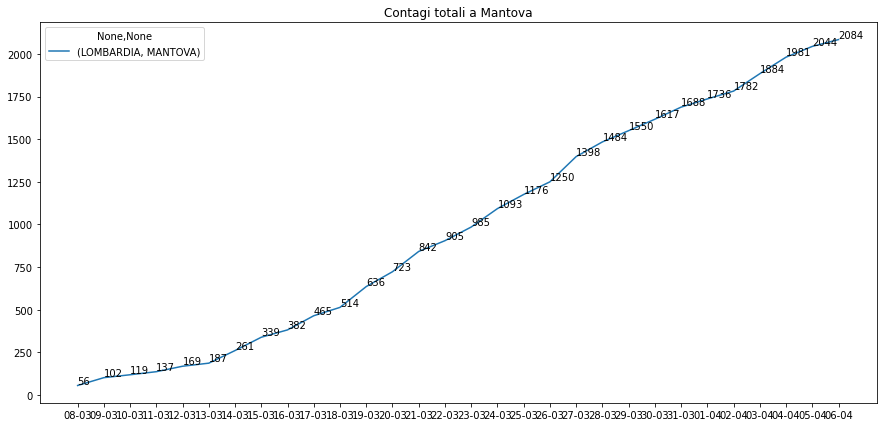

In [81]:
_ = plot_annotate(sorted_by_infections.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Contagi totali a Mantova')

# Average 3 days

In [0]:
avg3 = pd.DataFrame(index=sorted_by_infections.index)
for meno2,ieri, oggi in zip(crescita.columns[:-2], crescita.columns[1:-1], crescita.columns[2:]):
  avg3[oggi] = pd.concat([crescita[oggi], crescita[ieri], crescita[meno2]], axis=1).mean(axis=1)

In [0]:
avg3 = avg3.astype('int32')

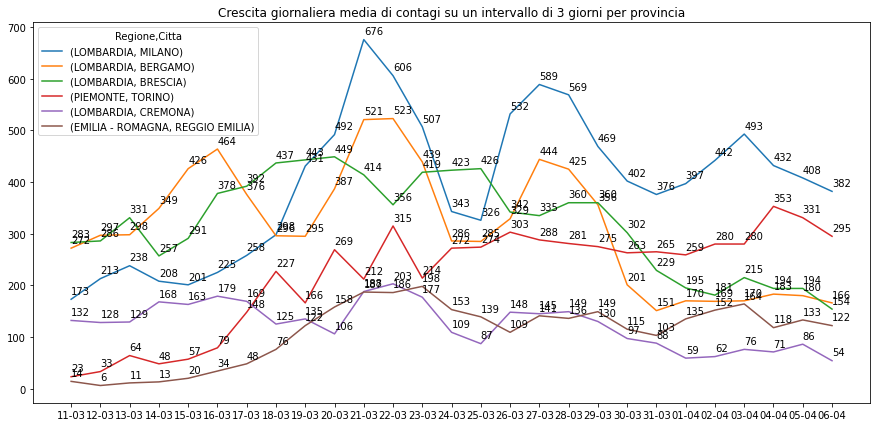

In [84]:
_ = plot_annotate(avg3.head(6), 'Crescita giornaliera media di contagi su un intervallo di 3 giorni per provincia')

In [0]:
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']

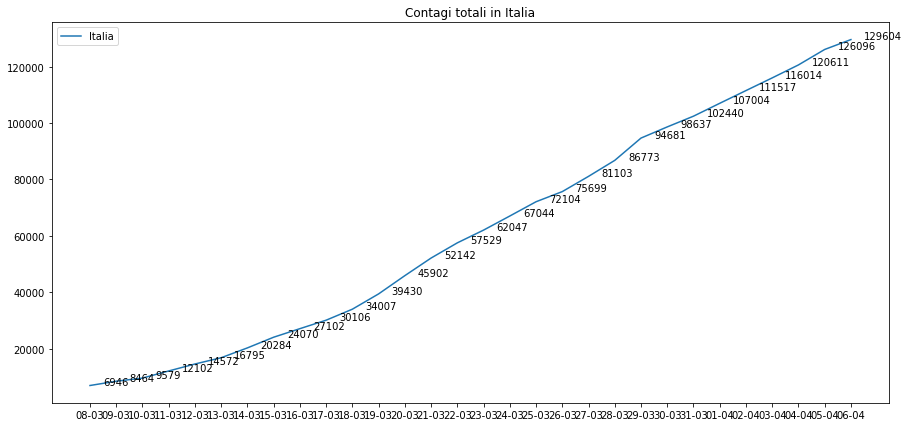

In [86]:
_ = plot_annotate(casi_italia, 'Contagi totali in Italia', xdelta=0.5)

In [0]:
crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']

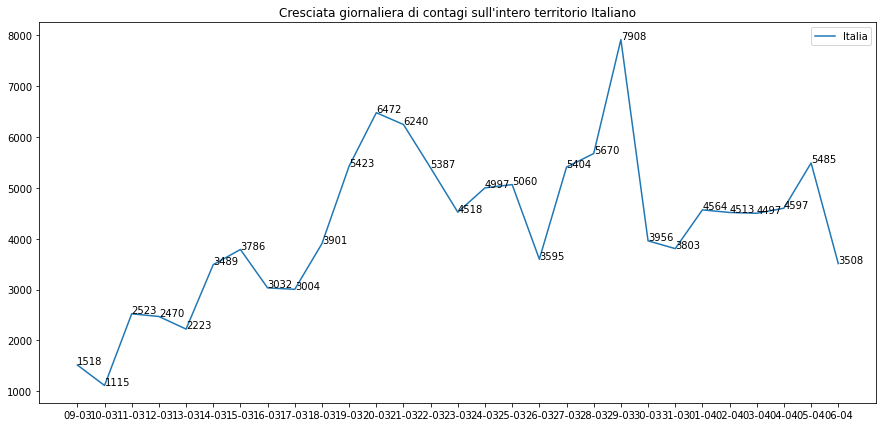

In [88]:
_ = plot_annotate(crescita_italia, 'Cresciata giornaliera di contagi sull\'intero territorio Italiano')

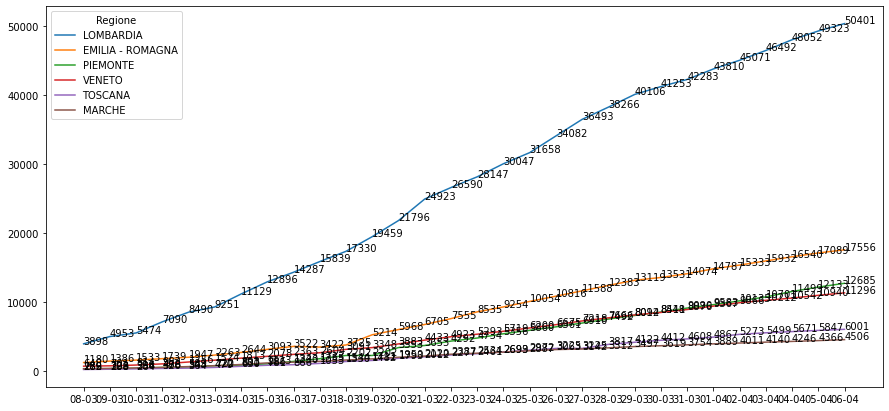

In [89]:
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)
_ = plot_annotate(regioni.head(6))

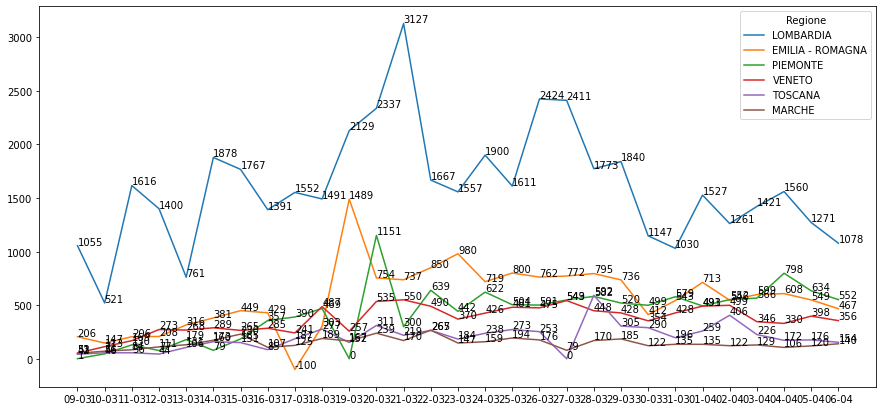

In [90]:
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(6))
